# CRISPR-RNA-Editing Using Structure Data
Harsh D. <br/>
Updated on 9/15/20
#### Notebook to train models based on 101 bp sequences and structure rates and the edit rates contained in the metadata for each sample in the .fasta file.

In [1]:
import os

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0" 

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, activations

In [2]:
tp = "ABE"
DATA_DIR = "crispr/data/CRISPR-{}-RNA-DATA/fastas/{}-sequence/".format(tp, tp)
STRUCT_DIR = "crispr/data/CRISPR-{}-RNA-DATA/fastas/{}-secondary/".format(tp, tp)


In [3]:
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

def seq_to_onehot(seq): 
    seq = seq.strip()
    values = list(seq+"ACTG") 
    label_encoder = LabelEncoder();
    integer_encoded = label_encoder.fit_transform(values);
    onehot_encoder = OneHotEncoder(sparse=False);
    integer_encoded = integer_encoded.reshape(len(integer_encoded), 1);
    onehot_encoded = onehot_encoder.fit_transform(integer_encoded); # encodes the sequence as a one hot vector
    return onehot_encoded[:-4] 
def struct_to_onehot(seq): 
    seq = seq.strip()
    values = list(".()"+seq) 
    label_encoder = LabelEncoder();
    integer_encoded = label_encoder.fit_transform(values);
    onehot_encoder = OneHotEncoder(sparse=False);
    integer_encoded = integer_encoded.reshape(len(integer_encoded), 1);
    onehot_encoded = onehot_encoder.fit_transform(integer_encoded); # encodes the structure as a one hot vector
    return onehot_encoded[3:] 
def editdata(line):
    data = line.split("_")
    return float(data[3])

In [4]:
from scipy import stats
def getSpearman(arr1, arr2):    
    return stats.spearmanr(arr1.astype("float64"), arr2.astype("float64"))

In [5]:
import time
def getData(chromosome):
    start = time.time()
    out = list()
    inp = list()
    with gzip.open(DATA_DIR+'{}.chr{}.fasta.gz'.format(exp, chromosome),'rt') as f:
        for line in f:
            if line[0:1] == ">":
                y = editdata(line)
                out.append(y)
            else:
                x = seq_to_onehot(line)
                assert x.shape[1] == 4
                inp.append(x)
    print(time.time()-start)
    X = np.stack(inp)
    Y = np.stack(out)
    print(Y.shape[0])
    return (X, Y.reshape(Y.shape[0], 1))
def getStructureData(chromosome):
    start = time.time()
    inp = list()
    with gzip.open(STRUCT_DIR+'{}.chr{}.structure.txt.gz'.format(exp, chromosome),'rt') as f:
        for line in f:
            #line = line.decode("utf-8")
            if line[0:1] == ">":
                continue
            else:
                x = struct_to_onehot(line)
                assert x.shape[1] == 3
                inp.append(x)
    print(time.time()-start)
    X = np.stack(inp)
    return X
def getComboData(chromosome):
    start = time.time()
    X_seq, Y = getData(chromosome)
    X_struct = getStructureData(chromosome)
    assert X_seq.shape[0] == X_struct.shape[0]
    n = X_seq.shape[0]
    inp = list()
    for a in range(n):
        lx = list()
        for x in range(101):
            l = np.zeros((12), dtype='float32')
            a_max = np.argmax(X_seq[a][x])
            b_max = np.argmax(X_struct[a][x])
            l[3*a_max+b_max] = 1
            lx.append(l)
        inp.append(np.stack(lx))
    X = np.stack(inp)
    end = time.time()
    X = X.astype('float32') 
    print("Combo chr-{} in {} sec.".format(chromosome, end-start))
    return (X, Y)

In [6]:
from multiprocessing import Pool

def load_data(chromosomes):
    start = time.time()
    num_workers = len(chromosomes)
    X_data = list()
    Y_data = list()
    with Pool(processes=num_workers) as pool:
        res = pool.map(getComboData, chromosomes)
        for tup in res:
            X_data.append(tup[0])
            Y_data.append(tup[1])
    X = np.concatenate(X_data, axis=0)
    Y = np.concatenate(Y_data, axis=0)
    print(time.time()-start)
    print("TOT: {}".format(X.shape[0]))
    return (X, Y)
        
    

In [7]:

import gzip
import time

test_set = ["20", "21", "22", "X"]
train_set = [str(x) for x in range(1, 23)]
train_set.append("X")
for e in test_set:
    train_set.remove(e)
print(train_set)
print(test_set)
Xtr = list()
Ytr = list()

train = ["156B"]
test = "158B"
 
for experiment in train:
    exp = experiment
    X, Y = load_data(train_set)
    Xtr.append(X)
    Ytr.append(Y)

X_train = np.concatenate(Xtr, axis=0)
Y_train = np.concatenate(Ytr, axis=0)

exp = test
X_test, Y_test = load_data(test_set)


['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19']
['20', '21', '22', 'X']
30.66553521156311
34345
34.41001105308533
38151
55.77419877052307
62624
57.40650248527527
64324
59.861244678497314
67685
30.02122473716736
61.140766859054565
69224
66.75036454200745
90018
33.44336724281311
72.76024889945984
84451
79.01836133003235
88969
80.6155116558075
91243
87.10998702049255
99850
100.9805805683136
113782
102.44268608093262
116020
105.63262915611267
119462
52.49194955825806
109.33457469940186
109.60941815376282
124179
123261
55.533384799957275
116.31307911872864
130922
56.85665702819824
58.693915128707886
Combo chr-18 in 123.93345403671265 sec.
125.80052399635315
152609
59.33147716522217
Combo chr-13 in 134.01649045944214 sec.
77.9044349193573
76.54950332641602
79.53564620018005
86.7087390422821
Combo chr-8 in 189.18690371513367 sec.
86.84062552452087
98.94891428947449
100.43369197845459
86.92052936553955
101.27833485603333
Combo chr-4 in 

In [8]:
X_train_dz = X_train.astype("float64")
Y_train_dz = Y_train
print(X_train_dz.shape)
print(Y_train_dz.shape)
X_test_dz = X_test.astype("float64")
Y_test_dz = Y_test
print(X_test_dz.shape)
print(Y_test_dz.shape)

(1945651, 101, 12)
(1945651, 1)
(166671, 101, 12)
(166671, 1)


In [11]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, activations, Model, backend
from tensorflow.keras.layers import Input, Conv1D, ReLU, BatchNormalization,\
                                    Add, Activation, AveragePooling2D, Flatten, Dense
import tensorflow.keras.backend as K
K.clear_session()
n = 50
def quartic_loss(y_true, y_pred):
    return K.square(K.square(y_true - y_pred))
def build_model():
    model = keras.Sequential(
        [
        layers.Input(shape=(2*n+1,12)),
        layers.Conv1D(128, 16, padding='same'),
        layers.BatchNormalization(),
        layers.Activation(activation='relu'),
        layers.Conv1D(128, 8, padding='same'),
        layers.BatchNormalization(),
        layers.Activation(activation='relu'),
        layers.Conv1D(64, 4, padding='same'),
        layers.BatchNormalization(),
        layers.Activation(activation='relu'),
        layers.Conv1D(64, 8, padding='same'),
        layers.BatchNormalization(),
        layers.Activation(activation='relu'),
        layers.Conv1D(32, 8, padding='same'),
        layers.BatchNormalization(),
        layers.Activation(activation='relu'),
        layers.Flatten(),
        layers.Dense(32, activation='tanh'),
        layers.BatchNormalization(),
        layers.Dense(1, activation='sigmoid'),
        ]
    )
    optimizer = tf.keras.optimizers.RMSprop(lr=0.01)
    model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
    return model
def build_func_model():
    dout = 0.3
    model = keras.Sequential(
        [
        layers.Input(shape=(2*n+1,12)),
        layers.Conv1D(128, 32, padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(dout),
        
        layers.Conv1D(64, 4, padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(dout),  
        layers.Conv1D(100, 4, padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(dout),  
        layers.MaxPooling1D(2, padding='same'),
        layers.Conv1D(100, 8, padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(dout),
        layers.Conv1D(50, 4, padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(dout),
        layers.MaxPooling1D(3, padding='same'),
        layers.Conv1D(100, 4, padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(dout),
        layers.MaxPooling1D(4, padding='same'),
        layers.Conv1D(100, 8, padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(dout),
        layers.Flatten(),
        layers.Dense(32, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(dout),
        layers.Dense(1, activation='sigmoid'),
        ]
    )
    optimizer = tf.keras.optimizers.RMSprop()
    model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
    return model
#def focal_loss(y_true, y_pred):
    
    
def build_resnet():
    inputs = keras.Input(shape=(2*n+1,12))
    lmc = 32
    s = 16
    conl = layers.Conv1D(lmc, 1, padding='same')(inputs)
    x = layers.Conv1D(lmc, 1, padding='same', activation='relu')(conl)
    y = rb(conl, lmc, s)
    y = rb(y, lmc, s)
    y = rb(y, lmc, s)
    y = rb(y, lmc, s)
    y = layers.Conv1D(lmc, 1, padding='same')(y)
    x = Add()([x,y])
    x = Conv1D(5, 1, padding='same')(x)
    x = Flatten()(x)
    output = Dense(1, activation='sigmoid')(x)
    model = Model(inputs, output)
    optimizer = tf.keras.optimizers.RMSprop()
    model.compile(loss="mse",
                optimizer=optimizer,
                metrics=['mae', 'mse'])
    return model
def rb(x, n, w):  
    y = layers.BatchNormalization()(x)
    y = Activation('relu')(y)
    y = Conv1D(n, w, padding='same')(y)
    y = layers.BatchNormalization()(y)
    y = Activation('relu')(y)
    y = Conv1D(n, w, padding='same')(y)
    out = Add()([x, y])
    return out
    

In [12]:
import time

model = build_func_model()
model.summary()

tp = "ABE"
now = str(int(time.time()))

checkpoint_filepath = 'crispr/models/validation/structure_net-{}-{}.h5'.format(tp, now)
print(checkpoint_filepath)
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
history = model.fit(x=X_train_dz[:,50-n:51+n,:], y=Y_train_dz, epochs=100, batch_size = 4096, validation_data = [X_test_dz[:,50-n:51+n,:], Y_test_dz], callbacks=[model_checkpoint_callback], use_multiprocessing=True)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 101, 128)          49280     
_________________________________________________________________
batch_normalization (BatchNo (None, 101, 128)          512       
_________________________________________________________________
dropout (Dropout)            (None, 101, 128)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 101, 64)           32832     
_________________________________________________________________
batch_normalization_1 (Batch (None, 101, 64)           256       
_________________________________________________________________
dropout_1 (Dropout)          (None, 101, 64)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 101, 100)          2

KeyboardInterrupt: 

In [13]:
model = tf.keras.models.load_model(checkpoint_filepath)
model.summary()

print(checkpoint_filepath)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 101, 128)          49280     
_________________________________________________________________
batch_normalization (BatchNo (None, 101, 128)          512       
_________________________________________________________________
dropout (Dropout)            (None, 101, 128)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 101, 64)           32832     
________________________________

In [14]:
Y_pred = model.predict(X_test_dz[:,50-n:51+n,:], batch_size=4096)

In [15]:
print(Y_pred.shape)
print(Y_test_dz.shape)


(166671, 1)
(166671, 1)


In [16]:
print(np.median(Y_test_dz))

0.0


In [17]:
Y_test_dz = Y_test_dz.reshape(Y_test_dz.shape[0], 1)

In [18]:
import scipy
print("Spearman Coeff:\t"+str(getSpearman(Y_pred, Y_test_dz)[0]))
print("Pearson Coeff:\t"+str(scipy.stats.pearsonr(Y_pred.flatten(), Y_test_dz.flatten())[0]))

Spearman Coeff:	0.3525974794119911
Pearson Coeff:	0.5345057489296693


In [19]:
def getSlope(test, pred):
    return np.polyfit(test, pred, 1)    
def rmse(test, pred):
    return np.sqrt(np.mean((test-pred)**2))

In [20]:
m, b = getSlope(Y_pred.flatten(), Y_test_dz.flatten())

In [21]:
print(m)
print(b)

0.9193382810001139
0.0008010831108565113


In [22]:
from scipy.stats import kde
import matplotlib.pyplot as plt
nbins=150
x = Y_pred.flatten()
y = Y_test_dz.flatten()
k = kde.gaussian_kde([x,y])
xi, yi = np.mgrid[x.min():x.max():nbins*1j, y.min():y.max():nbins*1j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))

In [23]:
print(np.median(zi))

3.591247258765708e-11


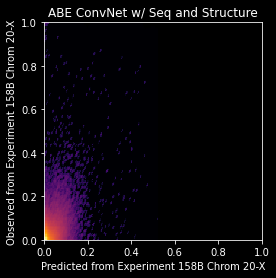

Spearman Coeff:	0.3525974794119911
Pearson Coeff: 0.5345057489296693
RMSE: 0.02897769843978701


In [26]:
from matplotlib import colors
import matplotlib
plt.style.use(['dark_background'])
exp = "158B Chrom 20-X"
plt.axis('square')
plt.ylabel("Observed from Experiment {}".format(exp))
plt.xlabel("Predicted from Experiment {}".format(exp))
plt.title("ABE ConvNet w/ Seq and Structure")
plt.xlim(0,1)
plt.ylim(0,1)
plt.pcolormesh(xi, yi, zi.reshape(xi.shape),cmap=plt.cm.inferno, norm=matplotlib.colors.LogNorm(vmin=1e-2), snap=False)
plt.show()
import scipy
print("Spearman Coeff:\t"+str(getSpearman(Y_pred, Y_test_dz)[0]))
print("Pearson Coeff: "+str(scipy.stats.pearsonr(Y_pred.flatten(), Y_test_dz.flatten())[0]))
print("RMSE: {}".format(rmse(Y_pred.flatten(), Y_test_dz.flatten())))

In [27]:
print(np.mean(Y_train_dz))
print(np.mean(Y_test_dz))

0.012207149740626666
0.013325501136970437
